In [83]:
import random

import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

from torchvision import datasets, transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader

def vis(model, dataset, target_classes=[1,10,4, 26,27,32]):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)
    model.eval()

    # create dataloaders for training and validation
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

    # Run the data through the model and store the output
    outputs = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            if targets[0] in target_classes:
                images = images.to(device)
                outputs_batch = model(images)
                outputs.append(outputs_batch.cpu().numpy())
                labels.append(targets.cpu().numpy())

    outputs = np.concatenate(outputs, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Apply PCA
    # pca = PCA(n_components=2)
    # pca.fit(outputs)
    # pca_transformed = pca.transform(outputs)
    
    # # Plot the results
    # fig, ax = plt.subplots()
    # for i in range(len(data.classes)):
    #     indices = np.where(labels == i)[0]
    #     ax.scatter(pca_transformed[indices, 0], pca_transformed[indices, 1], label=data.classes[i])
    # ax.legend()
    # plt.show()
    
    
    # t-SNEで埋め込みデータを2次元に削減
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(outputs)
    fig, ax = plt.subplots()
    for i in range(len(dataset.classes)):
        if i in target_classes:
            indices = np.where(labels == i)[0]
            ax.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=dataset.classes[i])
    ax.legend()
    plt.show()

    
    # k-NNで分類
    thr = 100
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(outputs[:thr], labels[:thr])

    print(f"train: {len(outputs[:thr])}")
    print(f"test: {len(outputs[thr:])}")

    # 埋め込みデータに対して分類の精度を計算
    train_preds = knn.predict(outputs[thr:])
    train_accuracy = np.mean(train_preds == labels[thr:])
    print(f"Training accuracy: {train_accuracy:.3f}")

In [72]:
def display_dataset(dataset):
    # クラスの数とクラス名を取得
    num_classes = len(dataset.classes)
    class_names = dataset.classes
    
    print(f"num_data: {len(dataset)}")
    print(f"num_classes: {num_classes}")
    print(f"class_names: {dataset.class_to_idx}")
    
    # 各クラスのサンプル画像を表示
    nrows = num_classes//4+1
    fig, axs = plt.subplots(nrows=nrows, ncols=4, figsize=(12, 3*nrows))

    class_name_to_sample_idx = {}
    for idx, (_, target) in enumerate(dataset):
        class_name_to_sample_idx[target] = idx
        
        if len(class_name_to_sample_idx) == num_classes:
            break
    
    for i, class_name in enumerate(class_names):
        sample_index = class_name_to_sample_idx[i]
        # 画像を取得し、テンソルからNumPy配列に変換
        image, _ = dataset[sample_index]
        image = image.numpy().transpose((1, 2, 0))
        
        # 画像を表示
        row = i // 4
        col = i % 4
        axs[row, col].imshow(image)
        axs[row, col].set_title(class_name)
        axs[row, col].axis("off")

    plt.tight_layout()
    plt.show()

In [73]:
# resize & to_tensor
resize = transforms.Compose([
    transforms.Resize((224, 224)),  # resize image to 224x224
    transforms.ToTensor(),  # convert image to tensor
])

# resize & to_tensor & normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize image to 224x224
    transforms.ToTensor(),  # convert image to tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
])

num_data: 3680
num_classes: 37
class_names: {'Abyssinian': 0, 'American Bulldog': 1, 'American Pit Bull Terrier': 2, 'Basset Hound': 3, 'Beagle': 4, 'Bengal': 5, 'Birman': 6, 'Bombay': 7, 'Boxer': 8, 'British Shorthair': 9, 'Chihuahua': 10, 'Egyptian Mau': 11, 'English Cocker Spaniel': 12, 'English Setter': 13, 'German Shorthaired': 14, 'Great Pyrenees': 15, 'Havanese': 16, 'Japanese Chin': 17, 'Keeshond': 18, 'Leonberger': 19, 'Maine Coon': 20, 'Miniature Pinscher': 21, 'Newfoundland': 22, 'Persian': 23, 'Pomeranian': 24, 'Pug': 25, 'Ragdoll': 26, 'Russian Blue': 27, 'Saint Bernard': 28, 'Samoyed': 29, 'Scottish Terrier': 30, 'Shiba Inu': 31, 'Siamese': 32, 'Sphynx': 33, 'Staffordshire Bull Terrier': 34, 'Wheaten Terrier': 35, 'Yorkshire Terrier': 36}


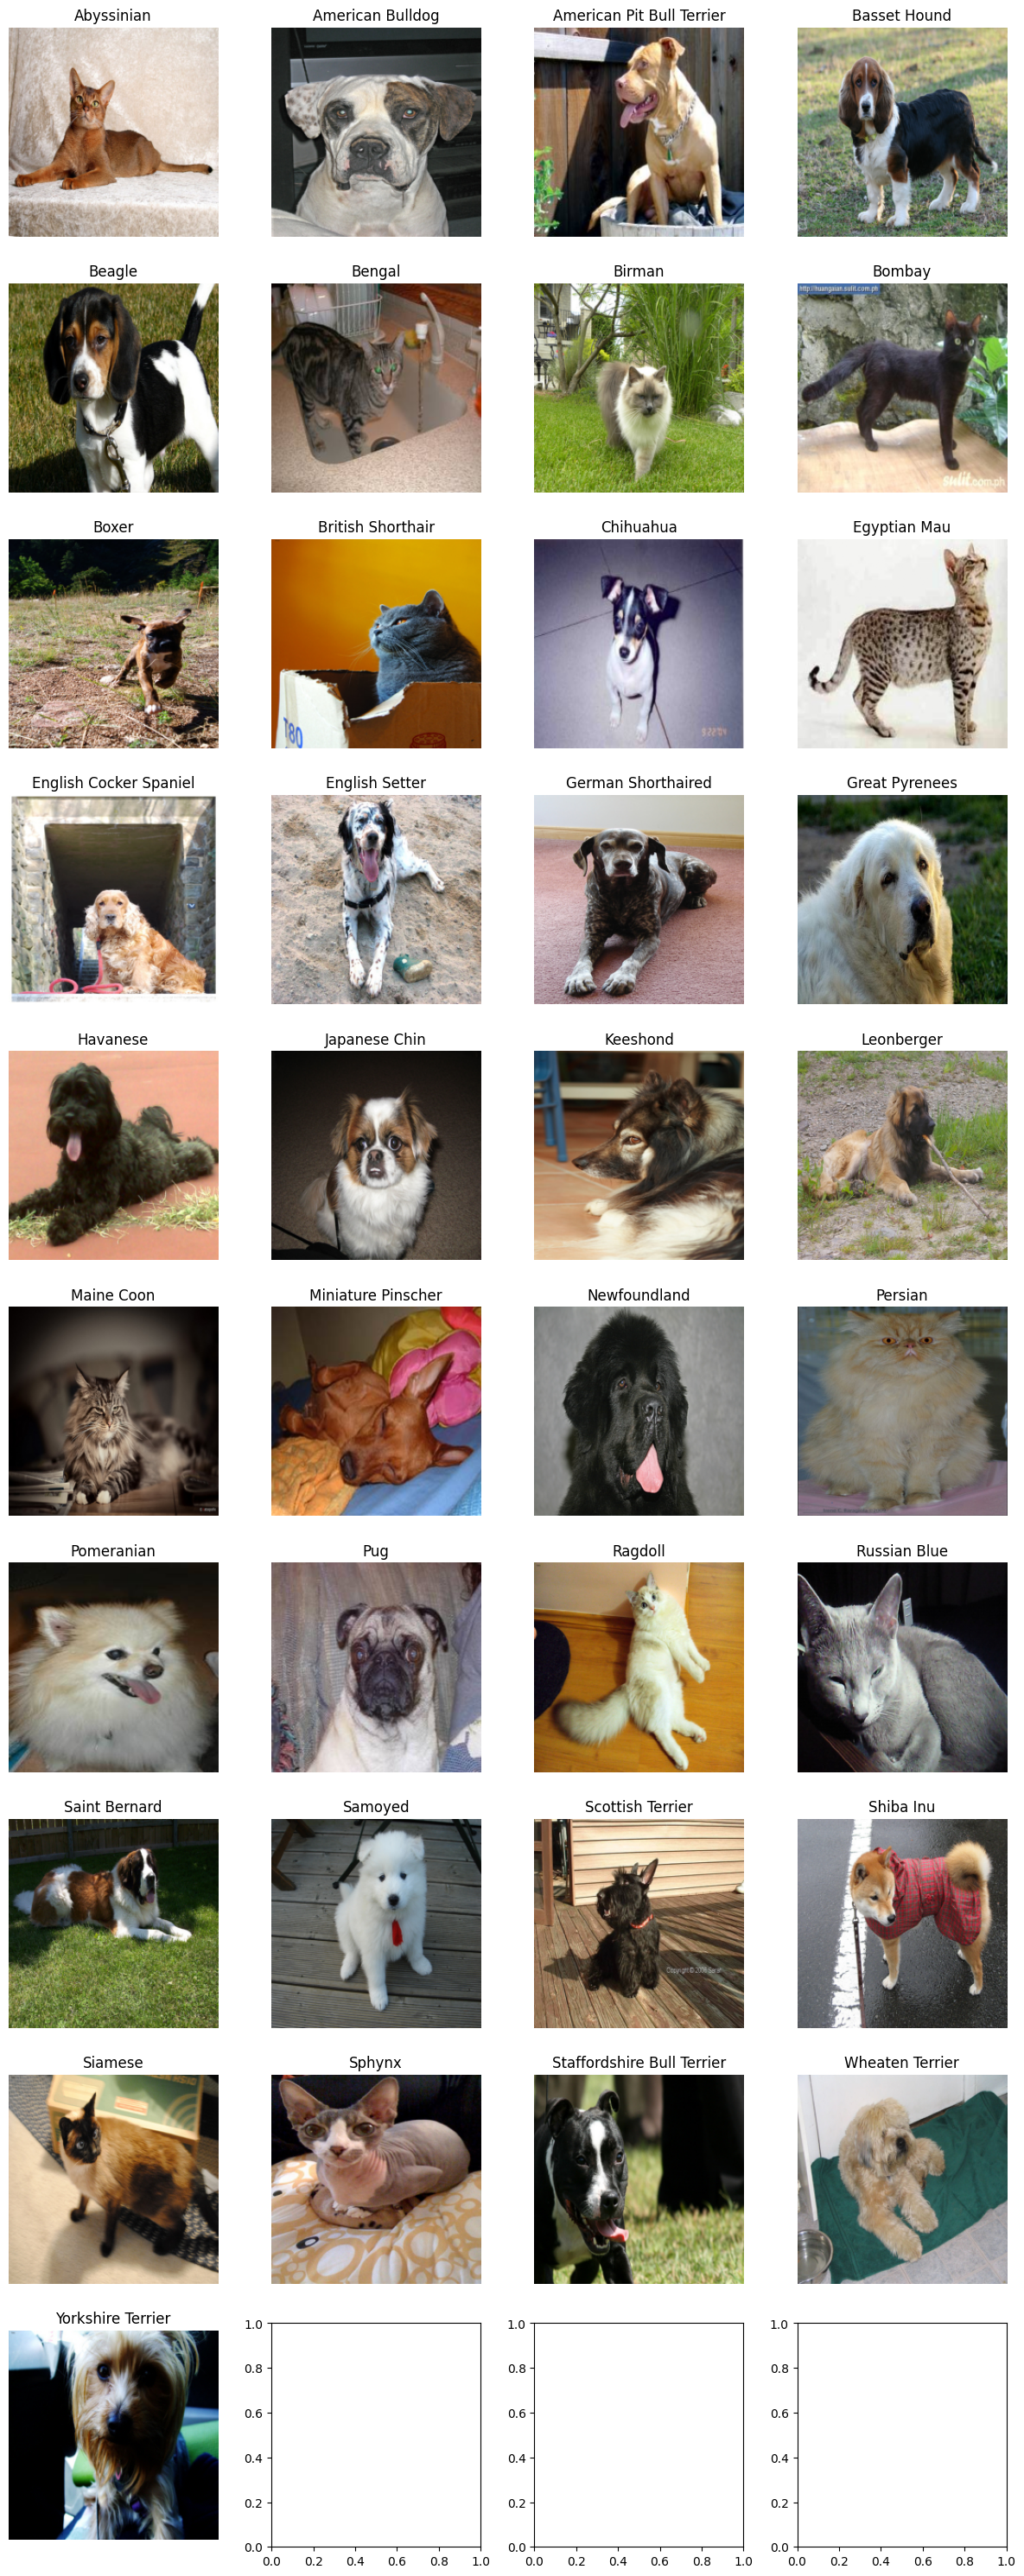

In [74]:
# Pipe
# Load the data
data_dir = '/workspace/datasets'

# create datasets for training and validation
dataset = OxfordIIITPet(data_dir, transform=resize, download=True)
display_dataset(dataset)
dataset = OxfordIIITPet(data_dir, transform=resize)

Using cache found in /home/duser/.cache/torch/hub/facebookresearch_dinov2_main


Using device: cuda


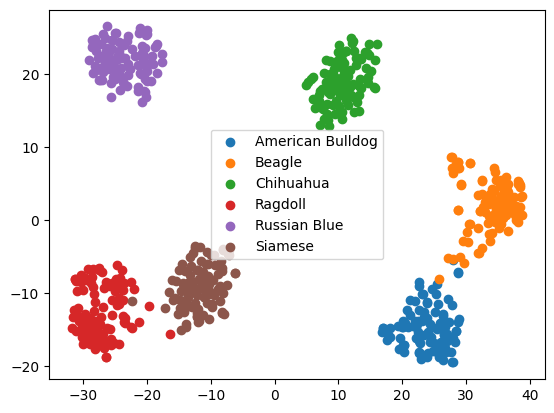

train: 100
test: 499
Training accuracy: 0.994


In [84]:
# DINOv2
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14') 
vis(dinov2, dataset)

Using cache found in /home/duser/.cache/torch/hub/facebookresearch_dino_main


Using device: cuda


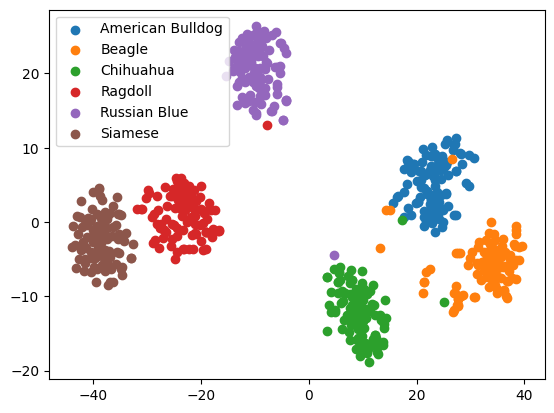

train: 100
test: 499
Training accuracy: 0.960


In [85]:
# DINOv1
dinov1 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
vis(dinov1, dataset)